# SMAD2

In [1]:
import gpsea
from gpsea.analysis.predicate import PatientCategories
from gpsea.preprocessing import load_phenopackets
from gpsea.preprocessing import configure_caching_cohort_creator
from gpsea.model import FeatureType, VariantEffect
from gpsea.view import CohortViewable
from gpsea.preprocessing import UniprotProteinMetadataService
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import VVMultiCoordinateService
from gpsea.view import ProteinVisualizable, ProteinVisualizer
import hpotk
from IPython.display import display, HTML

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.4.2.dev0


In [2]:
gene_symbol = 'SMAD2'
mane_tx_id = 'NM_005901.6'
mane_protein_id = 'NP_005892.1' # mothers against decapentaplegic homolog 2 isoform 1

In [10]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator

cohort_name = gene_symbol

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.20') as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(cohort_name))

## TODO -- UPDATE TO USE phenopacket store after next release
from pyphetools.visualization import PhenopacketIngestor
pp_dir = '/Users/robin/GIT/phenopacket-store/notebooks/SMAD2/phenopackets'
ingestor = PhenopacketIngestor(indir=pp_dir)
phenopackets = ingestor.get_phenopacket_list()

print(f'Loaded {len(phenopackets)} phenopackets')

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
validation.summarize()

[pyphetools] Ingested 23 GA4GH phenopackets.
Loaded 23 phenopackets
Individuals Processed: 100%|██████████| 23/23 [00:19<00:00,  1.17individuals/s]
Validated under permissive policy
No errors or warnings were found


In [11]:
cv = CohortViewable(hpo=hpo)
print(type(cohort))
report = cv.process(cohort=cohort, transcript_id=mane_tx_id);
report

<class 'gpsea.model._cohort.Cohort'>


HPO Term,ID,Seen in n individuals
Thoracic aortic aneurysm,HP:0012727,10
Scoliosis,HP:0002650,7
Arthralgia,HP:0002829,7
High palate,HP:0000218,7
Arachnodactyly,HP:0001166,6
Atrial septal defect,HP:0001631,5
Double outlet right ventricle,HP:0001719,5
Inguinal hernia,HP:0000023,5
Bruising susceptibility,HP:0000978,5
Tall stature,HP:0000098,5


/var/folders/hq/zttr8hjx127fgvh0bq7h4bc80000gn/T/ipykernel_30879/4229503970.py:3: DeprecationWarning: Use `configure_default_protein_metadata_service` instead
  pms = configure_protein_metadata_service()


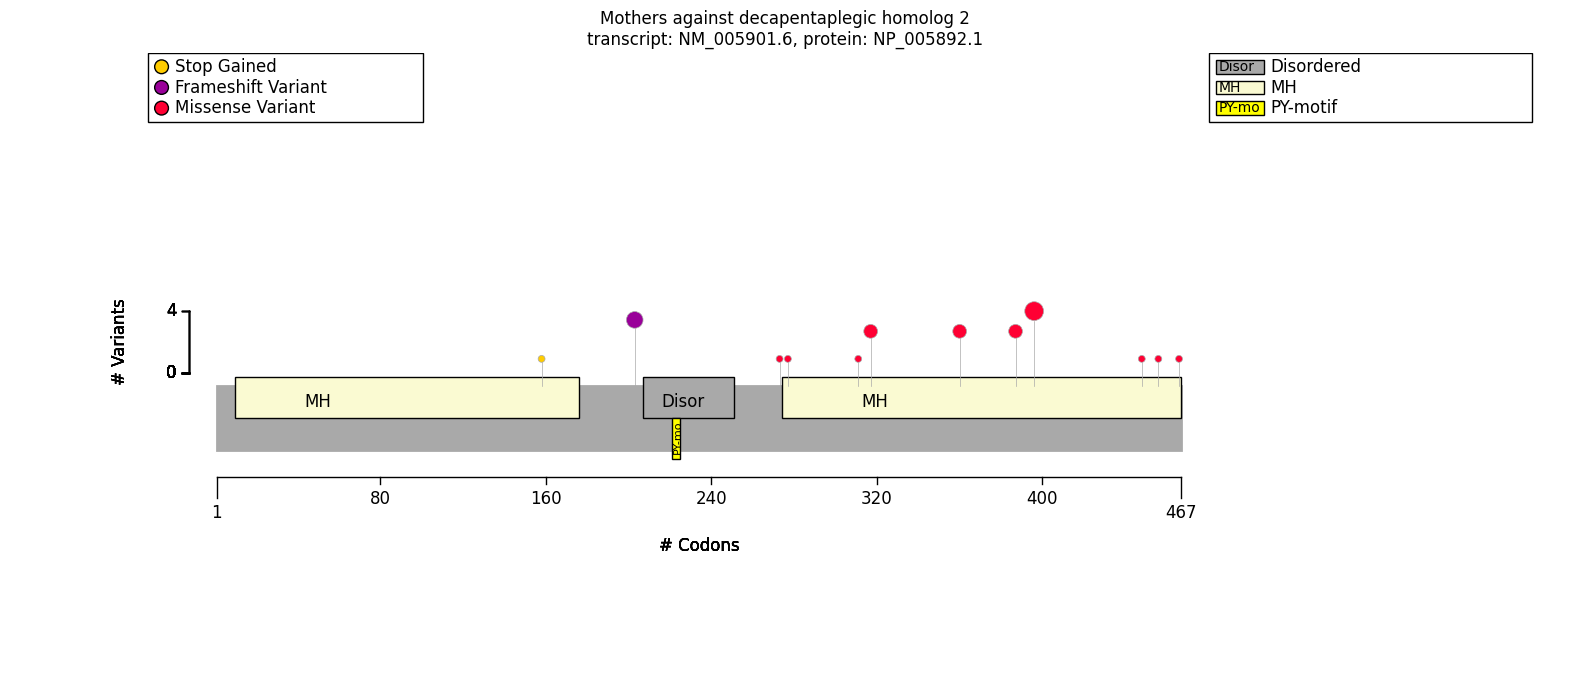

In [12]:
from gpsea.preprocessing import configure_protein_metadata_service

pms = configure_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(mane_tx_id)
pvis = ProteinVisualizable(tx_coordinates=tx_coordinates, protein_meta=protein_meta, cohort=cohort)
drawer = ProteinVisualizer()
drawer.draw_fig(pvis=pvis);

In [13]:
from gpsea.analysis.mtc_filter import HpoMtcFilter
mtc_filter = HpoMtcFilter.default_filter(
    hpo=hpo,
    term_frequency_threshold=0.2,
  #  cohort_size=len(cohort)
)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05

from gpsea.analysis.pcats.stats import FisherExactTest

count_statistic = FisherExactTest()
from gpsea.analysis.pcats import HpoTermAnalysis

analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)

from gpsea.model import FeatureType
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)
from gpsea.model import VariantEffect

In [14]:
from gpsea.analysis.predicate.genotype import VariantPredicates, autosomal_dominant
from gpsea.analysis.predicate import PatientCategories

is_variant = VariantPredicates.variant_key("18_47845430_47845430_G_T")
gt_predicate = autosomal_dominant(is_variant)

In [15]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
report = viewer.process(result)
report

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.2,3
HMF02,Skipping term because no genotype has more than one observed HPO count,1
HMF04,Skipping term because all genotypes have same HPO observed proportions,14
HMF05,Skipping term because one genotype had zero observations,4
HMF06,Skipping term with less than 7 observations (not powered for 2x2),116
HMF08,Skipping general term,63


In [16]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import summarize_hpo_analysis
summary_df = summarize_hpo_analysis(hpo, result)
summary_df

What is the genotype group                     HOM_REF           HET          \
                                                 Count Percent Count Percent   
Hypertelorism [HP:0000316]                        1/10     10%   3/4     75%   
Scoliosis [HP:0002650]                            7/10     70%   0/4      0%   
Arachnodactyly [HP:0001166]                       6/10     60%   0/4      0%   
Thoracic aortic aneurysm [HP:0012727]             9/12     75%   1/4     25%   
Inguinal hernia [HP:0000023]                       5/8     62%   0/3      0%   
Abnormal sternum morphology [HP:0000766]          5/11     45%   0/4      0%   
Dilatation of the cerebral artery [HP:0004944]     0/4      0%   2/4     50%   
Downslanted palpebral fissures [HP:0000494]        2/6     33%   0/4      0%   
Pes planus [HP:0001763]                            4/9     44%   0/2      0%   
Broad uvula [HP:0010809]                           2/7     29%   0/4      0%   
Carotid artery dissection [HP:0012158]             2/7     29%   0/4      0%   
Bruising susceptibility [HP:0000978]               2/5     40%   3/4     75%   
Varicose veins [HP:0002619]                        2/8     25%   2/4     50%   
Arthralgia [HP:0002829]                            5/7     71%   2/4     50%   
Tall stature [HP:0000098]                          4/7     57%   1/3     33%   
Dolichocephaly [HP:0000268]                        2/7     29%   1/4     25%   
High palate [HP:0000218]                          6/14     43%   1/4     25%   

What is the genotype group                                                   
                                               Corrected p values  p values  
Hypertelorism [HP:0000316]                               0.481185  0.040959  
Scoliosis [HP:0002650]                                   0.481185  0.069930  
Arachnodactyly [HP:0001166]                              0.481185  0.084915  
Thoracic aortic aneurysm [HP:0012727]                    0.502060  0.118132  
Inguinal hernia [HP:0000023]                             0.618182  0.181818  
Abnormal sternum morphology [HP:0000766]                 0.653846  0.230769  
Dilatation of the cerebral artery [HP:0004944]           0.699134  0.428571  
Downslanted palpebral fissures [HP:0000494]              0.699134  0.466667  
Pes planus [HP:0001763]                                  0.699134  0.490909  
Broad uvula [HP:0010809]                                 0.699134  0.490909  
Carotid artery dissection [HP:0012158]                   0.699134  0.490909  
Bruising susceptibility [HP:0000978]                     0.699134  0.523810  
Varicose veins [HP:0002619]                              0.699134  0.547475  
Arthralgia [HP:0002829]                                  0.699134  0.575758  
Tall stature [HP:0000098]                                1.000000  1.000000  
Dolichocephaly [HP:0000268]                              1.000000  1.000000  
High palate [HP:0000218]                                 1.000000  1.000000